# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [19]:
%matplotlib inline

In [20]:
from __future__ import print_function

In [21]:
import sys
sys.path.append("../../ilqr")
sys.path.append("../../")

In [22]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from torchdyn.models import NeuralODE

from cartpole import CartPoleDynamic, GeneralDyanmic
from cost import QRCost
from controller import iLQR

from dynamic import constrain
np.set_printoptions(suppress=True)

In [23]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = CartPoleDynamic.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [24]:
np.set_printoptions(suppress=True)

device = 'cpu'
grad = NeuralODE(CartPoleDynamic().to(device), sensitivity='adjoint', solver='rk4')
dynamics = GeneralDyanmic(0.02, grad, state_size=5, action_size=1)

In [25]:
# Note that the augmented state is not all 0.
x_goal = CartPoleDynamic.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
# Q[0, 2] = Q[2, 0] = pole_length
# Q[2, 2] = Q[3, 3] = pole_length ** 2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [44]:
N = 200
x0 = CartPoleDynamic.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
np.random.seed(0)
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [45]:
J_hist = []
xs, us = ilqr.fit(x0, np.concatenate([us, us2], axis=0), n_iterations=50, on_iteration=on_iteration)

iteration 0 accepted 3144.7210242816227 [ 2.25497937  0.53560394  2.75393407 -0.67993796]
iteration 1 accepted 1114.2968744254335 [0.17005545 0.60664427 2.38323861 0.99728698]
iteration 2 accepted 372.0179762547385 [-0.10403256 -0.04218729  1.93798145 -0.6142571 ]
iteration 3 accepted 316.35609423289924 [ 0.11130642  0.00510081  1.7097096  -0.33318636]
iteration 4 accepted 270.86224209997636 [ 0.04804971 -0.17667855  1.48976053 -0.05949122]
iteration 5 accepted 234.3474437655542 [ 0.15000181 -0.03680922  1.13857479 -0.10985824]
iteration 6 accepted 193.6778168806129 [ 0.0990363  -0.00114913  0.8804532  -0.28622833]
iteration 7 accepted 179.4531666429121 [ 0.08189557 -0.00044914  0.70676123 -0.34658432]
iteration 8 accepted 177.3513498678739 [ 0.04124812  0.01949513  0.59558058 -0.45306328]
iteration 9 accepted 165.11818881383186 [ 0.01875562 -0.03260422  0.55070804 -0.36614612]
iteration 10 accepted 162.0933962738958 [ 0.00535138 -0.01066628  0.51629228 -0.36571932]
iteration 11 accept

In [46]:
# Reduce the state to something more reasonable.
xs_reduced = CartPoleDynamic.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, -10, 10)

In [51]:
us

array([[-6.09296288],
       [-4.76938791],
       [-3.31075272],
       [-2.0499559 ],
       [-1.1628695 ],
       [-0.59606204],
       [-0.2357901 ],
       [ 0.00411888],
       [ 0.17569993],
       [ 0.30816335],
       [ 0.41756682],
       [ 0.51267156],
       [ 0.59835065],
       [ 0.67739195],
       [ 0.75150926],
       [ 0.82182738],
       [ 0.88921185],
       [ 0.95431733],
       [ 1.01762265],
       [ 1.0795159 ],
       [ 1.14022134],
       [ 1.19977601],
       [ 1.25804091],
       [ 1.31463361],
       [ 1.36897583],
       [ 1.42025602],
       [ 1.46742789],
       [ 1.5092843 ],
       [ 1.54448986],
       [ 1.57153444],
       [ 1.5890036 ],
       [ 1.59543259],
       [ 1.58957781],
       [ 1.57041068],
       [ 1.53725923],
       [ 1.48988889],
       [ 1.42854198],
       [ 1.35402636],
       [ 1.26770307],
       [ 1.17143171],
       [ 1.0674973 ],
       [ 0.95846008],
       [ 0.84702873],
       [ 0.73578965],
       [ 0.62706824],
       [ 0

In [48]:
dt=0.02
t = np.arange(N + 1) * dt
x = xs_reduced[:, 0]
x_dot = xs_reduced[:, 1]
theta = np.unwrap(xs_reduced[:, 2])  # Makes for smoother plots.
theta_dot = xs_reduced[:, 3]

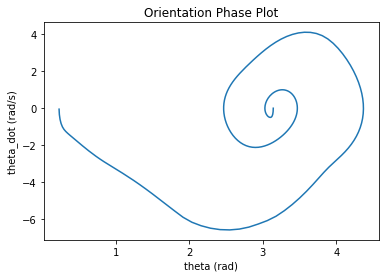

In [49]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

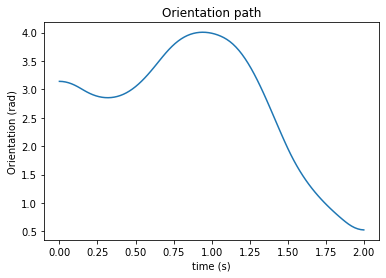

In [32]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

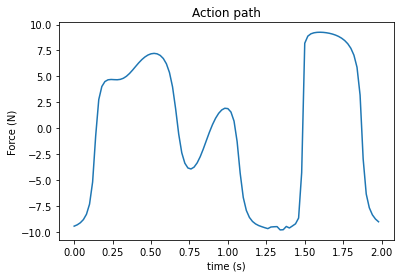

In [33]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

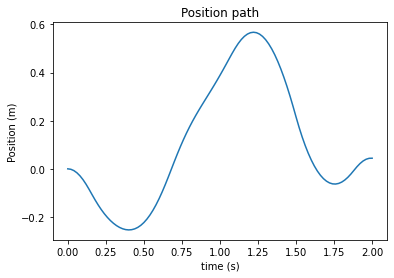

In [34]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

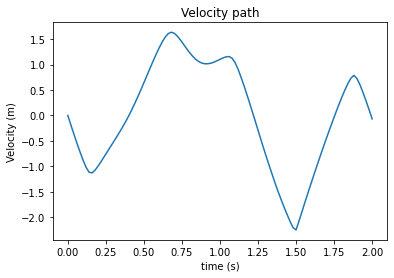

In [35]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

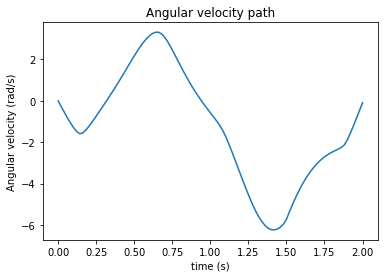

In [36]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

In [ ]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [ ]:
models = torch.load("../Cartpole/model/gradvsODEvsFD_new.pt")
lagODE_model = torch.load("../Cartpole/model/gradvsODEvsFD_lagODE_new.pt")
models.insert(1, lagODE_model)

for model in models:
    model.eval()
None

In [ ]:
test_dynamics = GeneralDyanmic(0.05, models[1], state_size=5, action_size=1)
ilqr = iLQR(test_dynamics, cost, N)

In [ ]:
J_hist = []
model_xs, model_us = ilqr.fit(x0, us_init, n_iterations=50, on_iteration=on_iteration)

In [ ]:
model_xs_reduced = CartPoleDynamic.reduce_state(model_xs)
model_us_constrained = constrain(model_us, -10, 10)

In [ ]:
t = np.arange(N + 1) * dt
x = model_xs_reduced[:, 0]
x_dot = model_xs_reduced[:, 1]
theta = np.unwrap(model_xs_reduced[:, 2])  # Makes for smoother plots.
theta_dot = model_xs_reduced[:, 3]

In [ ]:
theta[-1]

In [ ]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

In [ ]:
from gym_env import CartPoleCustomEnv

In [ ]:
env = CartPoleCustomEnv()
env.seed(0)
np.random.seed(0)

test_obs = []
test_infos = []

split = 20
test_obs0, _ = env.reset(np.array([0.0, 0.0, np.pi, 0.0]))

prev_obs = test_obs0

for i in range(50):
    test_obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(model_us_constrained[i])
    test_infos.append(np.array([info['th'], info['ddx'], info['ddth']]))
    
    prev_obs = next_obs
    last_us = us

In [ ]:
test_x = CartPoleDynamic.reduce_state(np.array(test_obs))

t = np.arange(N) * dt
theta = np.unwrap(test_x[:, 0])  # Makes for smoother plots.
theta_dot = test_x[:, 1]

In [ ]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

In [ ]:
# MPC
mpc_dynamics = GeneralDyanmic(0.02, models[2], state_size=5, action_size=1)
ilqr = iLQR(mpc_dynamics, cost, N)

In [ ]:
env = CartPoleCustomEnv()
env.seed(0)
np.random.seed(0)

all_us = []
all_xs = []
test_obs = []
test_infos = []

split = 20
test_obs0, _ = env.reset(np.array([0.0, 0.0, np.pi, 0.0]))

prev_obs = test_obs0
last_us = us_init

for i in range(50):
    print(i)
    test_obs.append(prev_obs)
    xs, us = ilqr.fit(prev_obs, last_us, n_iterations=20, on_iteration=on_iteration)
    all_us.append(us)
    all_xs.append(xs)
    
    next_obs, reward, done, info = env.step(us[0])
    test_infos.append(np.array([info['th'], info['ddx'], info['ddth']]))
    
    prev_obs = next_obs
    last_us = us

In [ ]:
test_x = CartPoleDynamic.reduce_state(np.array(test_obs))

t = np.arange(N) * dt
theta = np.unwrap(test_x[:, 0])  # Makes for smoother plots.
theta_dot = test_x[:, 1]

_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")